In [2]:
import nibabel as nib
import numpy as np
import pandas as pd
import nilearn.plotting as nip
import seaborn as sns
from matplotlib.colors import ListedColormap
from nibabel.affines import apply_affine
import numpy.linalg as npl
from nilearn.reporting import get_clusters_table
from scipy.ndimage import distance_transform_edt

from nilearn.datasets import fetch_atlas_difumo
difumo_data = fetch_atlas_difumo(dimension=128, resolution_mm=2, data_dir=None, resume=True, verbose=1, legacy_format=False)
# load 4d image and fetch the first volume
difumo_4d = nib.load(difumo_data['maps'])

def get_difumo_label(world_coord):
    voxel_coord = apply_affine(npl.inv(difumo_4d.affine), world_coord).astype(int)
    max = np.max(difumo_4d.get_fdata()[voxel_coord[0], voxel_coord[1], voxel_coord[2], :])
    argmax = np.argmax(difumo_4d.get_fdata()[voxel_coord[0], voxel_coord[1], voxel_coord[2], :])
    location = difumo_data['labels'].iloc[argmax, :]
    return location['difumo_names'], location['yeo_networks7'], max


mars_labelmap = nib.load('../resources/MNI152_nonlin_MarsAtlas.nii.gz')
mars_labels = pd.read_csv('../resources/MarsLabels_long.csv', index_col=False)

def get_mars_label(world_coord, max_radius=30):
    voxel_coord = apply_affine(npl.inv(mars_labelmap.affine), world_coord).astype(int)
    labelmap_data = mars_labelmap.get_fdata()
    nonzero_mask = labelmap_data > 0
    # Compute distance transform
    distances, indices = distance_transform_edt(~nonzero_mask, return_indices=True)
    # Get the closest non-zero label within the max_radius
    closest_voxel_coord = indices[:, voxel_coord[0], voxel_coord[1], voxel_coord[2]]
    # Ensure the closest voxel is within max_radius
    distance_to_closest = distances[tuple(voxel_coord)]
    if distance_to_closest > max_radius:
        return 0  # Return 0 if no non-zero label is within the radius
    label = labelmap_data[closest_voxel_coord[0], closest_voxel_coord[1], closest_voxel_coord[2]]
    res = mars_labels.loc[mars_labels['Index'] == label, :].copy()
    res.loc[:, 'Distance'] = distance_to_closest
    return res
   

dir_mediation = '/Users/tspisak/data/PIC_conditioning_withinsub_nodatalad/mediation_signflipped_signedquantile_studymod_results'
data4d_harmonized = nib.load(f'{dir_mediation}/../all_data_studyranked.nii')
pheno = pd.read_csv(f'{dir_mediation}/../signatures.csv')
# get mean effect in each group for a given voxel
def get_stats(voxel_coord, stat_fun, data4d=data4d_harmonized, pheno=pheno):
    data = data4d.get_fdata()[voxel_coord[0], voxel_coord[1], voxel_coord[2], :]
    return stat_fun(data, pheno)

def stat_fun_groupmeans(data, pheno):
    return np.mean(data[pheno['Conditioning']=='suggestions']), np.mean(data[pheno['Conditioning']=='suggestions & conditioning'])

def stat_fun_percgt0(data, pheno):
    mean_INT, mean_CONDINT = stat_fun_groupmeans(data, pheno)
    return (mean_INT+0.5)*100, (mean_CONDINT+0.5)*100 #weighted average (across studies) of the % of participants with a positive effect

my_cmp = ListedColormap(['cyan', 'blue', 'white', 'white', 'red', 'orange'])

/Users/tspisak/src/placebo-conditioning-meta-analysis/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
mask = nib.load(f'{dir_mediation}/../full_masked_10_percent.nii')
mask_data = mask.get_fdata()

contrast = [
    "PathA(XM)",
    "PathB(MY)",
    "Indirect(ACME)",
    "Direct(Total-Indirect)",
    "INST_mean",
    "CONDINST_mean",
    "INSTandCONDINST",
    ]
img_type = ['beta', 'thres', 'uncorr_logp', 'fdr_logq']

img = {}
for c in contrast:
    img[c] = {}
    for t in img_type:
        img[c][t] = nib.load(f'{dir_mediation}/{t}_{c}.nii.gz')

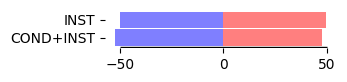

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
plt.style.use('default')

def bars(x, y, z):
    #world to voxel
    fig = plt.figure(figsize=(3, 0.5))
    x, y, z = apply_affine(npl.inv(img['PathA(XM)']['beta'].affine), (x, y, z)).astype(int)
    condinst = (img['CONDINST_mean']['beta'].get_fdata()[x, y, z]+0.5)*100 # % of participants with a positive effect
    inst = (img['INST_mean']['beta'].get_fdata()[x, y, z]+0.5)*100

    # plot horizontal barplot
    plt.barh(['COND+INST', 'INST'], [condinst, inst], height=0.9, color=to_rgba('red', 0.5))
    plt.barh(['COND+INST', 'INST'], [condinst-100, inst-100], height=0.9, color=to_rgba('blue', 0.5))
    plt.xticks([-50, 0, 50])
    #plt.axline((-10, 0.5), (0, 0.5), color='black', linewidth=1)
    plt.hlines(y=-0.5, xmin=-50, xmax=50, color='black', linewidth=1)
    #plt.tight_layout()
    sns.despine(left=True, bottom=True)
    #return df

# test it
bars(-10, 0, 0)

## MricroGL scripts
We select slices with at least n_sign significant voxels

In [5]:
from nilearn.plotting import find_cut_slices
coords = find_cut_slices(img['PathA(XM)']['uncorr_logp'], direction="z", n_cuts=9)
coords = ' '.join(str(z) for z in coords)
f'A H -0.1 V -0.1 {coords} S X R 0'


'A H -0.1 V -0.1 -44.0 -32.0 -16.0 -6.0 10.0 28.0 44.0 58.0 70.0 S X R 0'

In [6]:
nip.view_img(img['PathA(XM)']['thres']).open_in_browser()

/Users/tspisak/src/placebo-conditioning-meta-analysis/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [10]:
clust_table = get_clusters_table(stat_img=img['PathA(XM)']['uncorr_logp'],
                                 stat_threshold=-np.log10(0.01),
                                 cluster_threshold=10,
                                 min_distance=20
                                 )

clust_table['region'] = 'N/A'
clust_table['yeo_network'] = 'N/A'

# convert pandas column type row type to int
clust_table['X'] = clust_table['X'].astype(int)
clust_table['Y'] = clust_table['Y'].astype(int)
clust_table['Z'] = clust_table['Z'].astype(int)

for i, row in clust_table.iterrows():
    x, y, z = row['X'], row['Y'], row['Z']
    x_vox, y_vox, z_vox = apply_affine(npl.inv(img['PathA(XM)']['beta'].affine), (x, y, z)).astype(int)
    clust_table.loc[row.name, 'Effect size'] = np.round(img['PathA(XM)']['beta'].get_fdata()[x_vox, y_vox, z_vox]*100,1)
    clust_table.loc[row.name, 'Direction'] = np.sign(clust_table.loc[row.name, 'Effect size'])
    
    clust_table.loc[row.name, 'Mean INST'] = np.round(img['INST_mean']['beta'].get_fdata()[x_vox, y_vox, z_vox]*100+50, 1)
    clust_table.loc[row.name, 'Mean COND'] = np.round(img['CONDINST_mean']['beta'].get_fdata()[x_vox, y_vox, z_vox]*100+50, 1)
    
    mars_region = get_mars_label([x, y, z])
    clust_table.loc[row.name, 'Mars region'] = mars_region['Hemisphere'].values[0] + ' ' + mars_region['Full_name'].values[0] 

    region, yeo_nw, prob = get_difumo_label([x, y, z])
    clust_table.loc[row.name, 'DiFuMo region'] = region
    clust_table.loc[row.name, 'yeo_network'] = yeo_nw

    clust_table.loc[row.name, 'Peak Stat uncorr'] = 10 ** (-row['Peak Stat'])
    if clust_table.loc[row.name, 'Peak Stat uncorr'] < 0.0001:
        clust_table.loc[row.name, 'Peak Stat uncorr'] = '<0.0001'
    clust_table.loc[row.name, 'Peak Stat FDR'] = 10 ** (- img['PathA(XM)']['fdr_logq'].get_fdata()[x_vox, y_vox, z_vox])
    
    # delete row if peak is not fdr significant
    if clust_table.loc[row.name, 'Peak Stat FDR'] > 0.05:
        clust_table.drop(row.name, inplace=True)
        continue
    
    if clust_table.loc[row.name, 'Peak Stat FDR'] < 0.0001:
        clust_table.loc[row.name, 'Peak Stat FDR'] = '<0.0001'
        

    ### specific for path A
    pgt0_INT, pgt0_CONDINT = get_stats(voxel_coord=(x_vox, y_vox, z_vox), stat_fun=stat_fun_percgt0)
    # weighted average (across studies) of the % of participants with a positive effect
    clust_table.loc[row.name, 'perc_gt0_INT'] = pgt0_INT
    clust_table.loc[row.name, 'perc_gt0_CONDINT'] = pgt0_CONDINT
    # difference in % of participants with a positive effect - when modelling sex and age
    clust_table.loc[row.name, 'perc_gt0_diff'] = pgt0_CONDINT - pgt0_INT

pd.set_option("display.precision", 5)
clust_table[['Cluster ID', 'Cluster Size (mm3)', 'X', 'Y', 'Z', 'Mean INST', 'Mean COND',
     'Effect size', 'Peak Stat uncorr', 'Peak Stat FDR', 'Mars region', 'DiFuMo region', 'yeo_network', ]]

/var/folders/rc/b4064_3d4dj60wt9y_447fyr0000gn/T/ipykernel_44841/2223270658.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<0.0001' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  clust_table.loc[row.name, 'Peak Stat uncorr'] = '<0.0001'
/var/folders/rc/b4064_3d4dj60wt9y_447fyr0000gn/T/ipykernel_44841/2223270658.py:48: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<0.0001' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  clust_table.loc[row.name, 'Peak Stat FDR'] = '<0.0001'


,Cluster ID,Cluster Size (mm3),X,Y,Z,Mean INST,Mean COND,Effect size,Correlation,Peak Stat uncorr,Peak Stat FDR,Mars region,DiFuMo region,yeo_network
0,1,10544,64,-42,18,55.8,49.1,-9.89988,-0.2,<0.0001,<0.0001,Right Caudal Middle Temporal Cortex,Angular gyrus RH,DorsAttnB
1,1a,,50,-4,8,49.5,48.8,-9.57251,-0.2,<0.0001,<0.0001,Right Ventral Motor Cortex,Central operculum cortex,SomMotA
2,1b,,54,-18,28,51.5,42.4,-8.20811,-0.1,<0.0001,<0.0001,Right Dorsal Inferior Parietal Cortex,Supramarginal gyrus anterior RH,SalVentAttnA
3,1c,,58,-38,18,52.3,46.1,-7.84655,-0.1,<0.0001,<0.0001,Right Caudal Superior Temporal Cortex,Angular gyrus RH,DorsAttnB
4,2,520,-26,-62,10,42.7,29.4,-8.12383,-0.1,<0.0001,<0.0001,Left Rostral Medial Visual Cortex,Intracalcarine cortex,VisCent
5,3,392,-26,50,30,51.3,45.6,-8.39572,-0.1,<0.0001,<0.0001,Left Rostral Dorsolateral Superior Prefrontal ...,Superior frontal sulcus anterior,DefaultB
6,4,1160,-14,-46,70,48.7,41.0,-9.01556,-0.2,<0.0001,<0.0001,Left Dorsomedial Somatosensory Cortex,Paracentral lobule,SomMotA
7,5,808,-6,-88,6,45.5,44.9,-8.46841,-0.1,<0.0001,<0.0001,Left Cuneus,Calcarine cortex posterior,VisCent
8,6,1352,-4,-4,6,42.8,39.6,-8.04378,-0.1,<0.0001,<0.0001,Left Thalamus,Thalamus,No network found
9,7,648,2,-66,-24,40.1,34.1,-9.80946,-0.2,<0.0001,<0.0001,Right Caudal Medial Visual Cortex,Cerebellum VI anterior,No network found


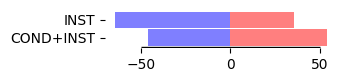

In [188]:
bars(62.0,-18.0,-18.0) # 1,240,62.0,-18.0,-18.0,0.356179,0.539447,0.183269,<0.0001,<0.0001,Right Rostral Middle Temporal Cortex,Middle temporal gyrus RH,DefaultB


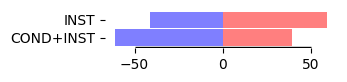

In [191]:
bars(52.0,-10.0,30.0) # 9,584,52.0,-10.0,30.0,0.589695,0.390684,-0.199010,<0.0001,<0.0001,Right Dorsolateral Somatosensory Cortex,Central sulcus,SomMotA


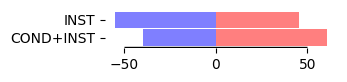

In [204]:
bars(2.0,32.0,44.0) #3,256,2.0,32.0,44.0,0.453372,0.605502,0.152130,<0.0001,<0.0001,Right Caudal Dorsomedial Prefrontal Cortex,Paracingulate gyrus middle,ContA


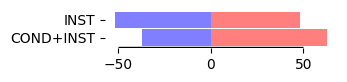

In [192]:
bars(26.0,48.0,36.0) # 6,832,26.0,48.0,36.0,0.483412,0.626463,0.143050,<0.0001,<0.0001,Right Rostral Dorsolateral Superior Prefrontal Cortex,Superior frontal sulcus,DefaultB


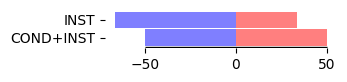

In [193]:
bars(46.0,-68.0,46.0) #8,688,46.0,-68.0,46.0,0.337934,0.500093,0.162159,<0.0001,<0.0001,Right Dorsal Inferior Parietal Cortex,Angular gyrus superior RH,ContA
